# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
#importar librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# cargar dataset
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
#revisar si hay valores nulos, y si existen outliers
print(data.isna().sum())
print(data.describe())
print()
print(data.value_counts(sort=False))

num_orders    0
dtype: int64
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

num_orders
0             537
1             584
2             595
3             661
4             820
             ... 
94              1
95              1
98              1
99              1
119             2
Length: 81, dtype: int64


In [4]:
# revisar si el orden del dataset es cronológico
data.sort_index(inplace=True)
print(data.index.is_monotonic_increasing)


True


In [5]:
# aplicar remuestreo en intervalos de 1 hora
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Análisis

<AxesSubplot:xlabel='datetime'>

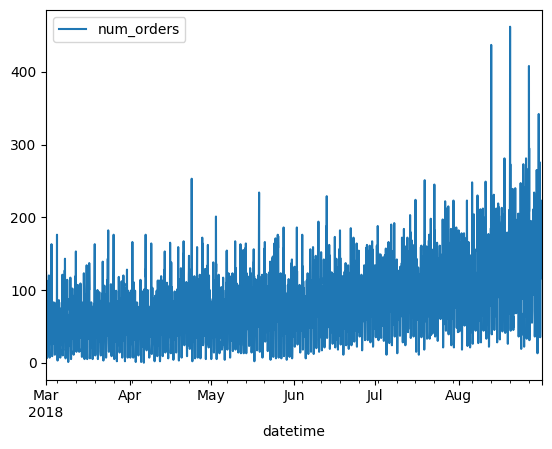

In [6]:
data_copy = data.copy()
data_copy.plot()

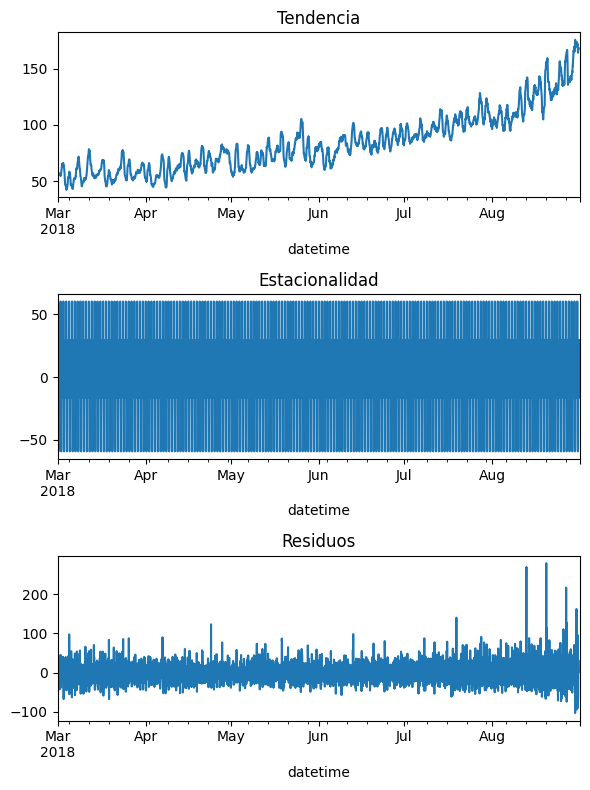

In [7]:
#análisis de las series temporales
decomposed = seasonal_decompose(data_copy)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuos')
plt.tight_layout()


En el gráfico de tendencia se observa un crecimiento general desde marzo hasta agosto de 2018, donde a pesar del ruido o fluctuaciones diarias, el valor general aumenta. Esto podría deberse a factores como un aumento en la demanda, crecimiento del mercado, etc.

El gráfico de estacionalidad sugiere un patrón repetitivo muy marcado que parece variar en ciclos muy cortos (probablemente diarios) donde la amplitud es relativamente constante (de -60 a +60), por lo que la estacionalidad no está cambiando mucho a lo largo del tiempo.

También, las gráficas sugieren que la serie no es estacionaria, porque tiene una tendencia ascendente.

<AxesSubplot:xlabel='datetime'>

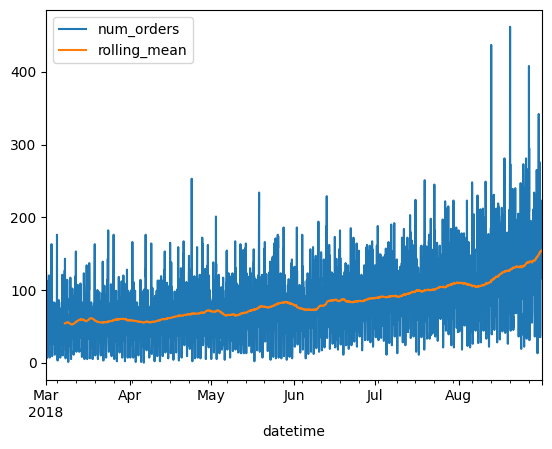

In [8]:
# obtener la media móvil con una ventana de 168, para suavizar una semana completa
data_copy['rolling_mean'] = data_copy.rolling(168).mean()
data_copy.plot()


La media móvil confirma que la serie no es estacionaria.

<AxesSubplot:xlabel='datetime'>

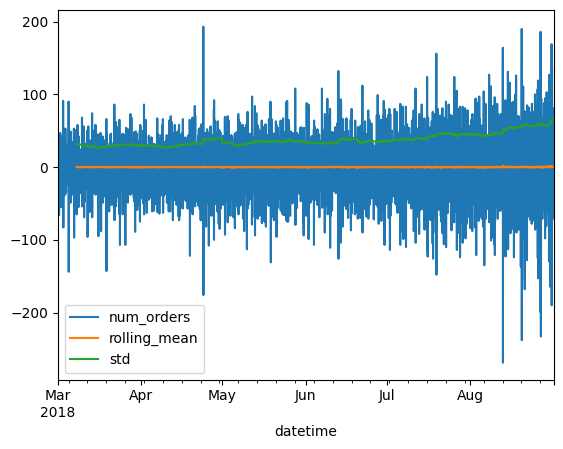

In [9]:
# encontrar la diferencia de la serie temporal para volverla estacionaria
data_copy -= data_copy.shift()
data_copy['std'] = data_copy['num_orders'].rolling(168).std()
data_copy.plot()


## Formación

In [10]:
#crear columnas para entrenar el modelo

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

# max lag de 120 para tener 5 días de historial, y rolling mean size de 48 para suavizar dos días
make_features(data, 120, 48)

data


,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,208.0,408.0,222.0,263.0,238.0,145.0,107.0,122.0,126.0,170.895833
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,295.0,208.0,408.0,222.0,263.0,238.0,145.0,107.0,122.0,170.208333
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,62.0,295.0,208.0,408.0,222.0,263.0,238.0,145.0,107.0,169.437500


In [11]:
#crear conjuntos de entrenamiento y prueba

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


In [12]:
# entrenamiento de modelo de regresión lineal
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)

pred_train_linear = model_linear.predict(features_train)

print("RMSE para el conjunto de entrenamiento:",mean_squared_error(target_train, pred_train_linear)) 

RMSE para el conjunto de entrenamiento: 473.5513690014732


In [13]:
# entrenamiento de modelo de árbol de decisión
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 6):
    model_tree = DecisionTreeRegressor(random_state = 12345, max_depth=depth)
    model_tree.fit(features_train, target_train) 
    pred_train_tree = model_tree.predict(features_train) 
    result = mean_squared_error(target_train, pred_train_tree)**0.5 
    if result < best_result:
        best_model = model_tree
        best_result = result
        best_depth = depth

print(f"RMSE del mejor modelo en el conjunto de entrenamiento (max_depth = {best_depth}): {best_result}")


RMSE del mejor modelo en el conjunto de entrenamiento (max_depth = 5): 23.26069601643715


In [14]:
# entrenamiento de modelo de bosque aleatorio
best_error = 10000 # configura el inicio de RECM
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model_forest = RandomForestRegressor(random_state = 54321, n_estimators = est, max_depth = depth)
        model_forest.fit(features_train, target_train)
        pred_train_forest = model_forest.predict(features_train) 
        error = mean_squared_error(target_train, pred_train_forest) ** 0.5 
        if error < best_error: # guarda la configuración del modelo si se logra el error más bajo
            best_error = error
            best_est = est
            best_depth = depth

print("RMSE del mejor modelo en el conjunto de entrenamiento:", best_error, "n_estimators:", best_est, "best_depth:", best_depth)


RMSE del mejor modelo en el conjunto de entrenamiento: 12.58907943356166 n_estimators: 40 best_depth: 10


## Prueba

In [15]:
# prueba de modelo de regresión lineal
pred_test_linear = model_linear.predict(features_test)
print("RMSE para el conjunto de prueba:",mean_squared_error(target_test, pred_test_linear)**0.5) 

RMSE para el conjunto de prueba: 40.25232705288978


In [16]:
#prueba de modelo de árbol de decisión
#model_tree = DecisionTreeRegressor(random_state = 12345, max_depth=5)
#model_tree.fit(features_train, target_train) 
pred_test_tree = model_tree.predict(features_test)
result = mean_squared_error(target_test, pred_test_tree)**0.5
print("RMSE para el conjunto de prueba:", result)

RMSE para el conjunto de prueba: 56.37678075543206


In [17]:
#prueba de modelo de bosque aleatorio
#model_forest = RandomForestRegressor(random_state = 54321, n_estimators = 40, max_depth = 10)
#model_forest.fit(features_train, target_train)
pred_test_forest = model_forest.predict(features_test)
error = mean_squared_error(target_test, pred_test_forest) ** 0.5
print("RMSE para el conjunto de prueba:", error)

RMSE para el conjunto de prueba: 40.16687644369476


## Conclusión

Se aumentó el max_lag a 120 para añadir más memoria del pasado al modelo (5 días en intervalos de 1 hora) y la media móvil de 48 para suavizar el promedio. Con estos ajustes, se logró un RMSE de 40.16 en el conjunto de prueba con el bosque aleatorio, después de probar varios hiperparámetros con cada modelo.

Hallazgos:
Aumentar max lag: Se añade más memoria del pasado al modelo, por lo que tiene más datos de dónde aprender. Pero existe riesgo de agregar ruido o sobreajuste, y aumenta el costo computacional. 

Disminuir max_lag: menor riesgo de sobreajuste, pero también menos capacidad para detectar patrones de largo plazo debido a la menor información histórica

Aumentar rolling_mean_size: el promedio se suaviza más, y vuelve más estacionaria la serie; mejora la captura de tendencias a largo plazo. Pero reacciona más lento a cambios.

Disminuir rolling_mean_size: menos suave y serie más sensible al ruido. Responde más rápido a cambios.

